In [1]:
#Sources used: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
#              https://medium.com/@ODSC/how-to-leverage-pre-trained-layers-in-image-classification-31fb9b8cdd0
#              https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
#Also based this a lot on the work of the other teammates too :)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from pandas.io.json import json_normalize
import seaborn as sns

from PIL import Image
from io import BytesIO
import requests

import tensorflow
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
# imports for loading and viewing image 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data = pd.read_json("https://raw.githubusercontent.com/TiernonRR/Dank_AIT/master/text_analysis/dank_cleaned.json")
data['ups_normed'] = data['ups']/data['subscribers']

In [5]:
def data_delimit(threshold): #take a percentage, consider all memes that have more upvotes than this percentile to be dank
    data['dank_level'] = data['ups_normed'].apply(lambda x: 1 if x >= data['ups_normed'].quantile(threshold) else 0)

In [6]:
data_delimit(0.95) #considering 5% of memes to be dank

In [7]:
data.head(5)

,author,awards,created_utc,text_from_image,words,processed_words,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,ups_normed,dank_level
1,L71U,[],1584295514,NICE DICK\r\n,Ricardo😎NICE DICK\r\n,"[ricardo, nice, dick]",0,fj5ixk,False,https://i.redd.it/w6acm47gmvm41.jpg,r/dank_meme,743116,136.0,https://b.thumbs.redditmedia.com/PixKjoPWVw738...,140.0,Ricardo😎,35,/r/dank_meme/comments/fj5ixk/ricardo/,0.000047,0
2,Awesome-ness5,[],1584294841,Nvidia's calling on gaming PC owners to\r\nput...,Gamers AssembleNvidia's calling on gaming PC o...,"[gamer, assemblenvidia, call, game, owner, sys...",0,fj5bzj,False,https://i.redd.it/bqawbb5gkvm41.jpg,r/dank_meme,743116,140.0,https://b.thumbs.redditmedia.com/Fj8eeEt78J-I6...,140.0,Gamers Assemble,11,/r/dank_meme/comments/fj5bzj/gamers_assemble/,0.000015,0
5,None,[],1584293979,JANUARY\r\nFEBRUARY\r\nMARCH\r\nAPRIL\r\ncnu\r...,2020 in a nutshellJANUARY\r\nFEBRUARY\r\nMARCH...,"[nutshelljanuari, februari, march, april, plag...",0,fj53jo,False,https://i.imgur.com/7LmxYnC.png,r/dank_meme,743116,140.0,default,140.0,2020 in a nutshell,1,/r/dank_meme/comments/fj53jo/2020_in_a_nutshell/,0.000001,0
7,notaspop,[],1584293653,When you post a low-effort meme\r\nfor fun to ...,I mean.... Not Corona time?When you post a low...,"[mean, corona, time, post, effort, meme, peopl...",0,fj50df,False,https://i.redd.it/v5pea6wwgvm41.jpg,r/dank_meme,743116,140.0,default,140.0,I mean.... Not Corona time?,1,/r/dank_meme/comments/fj50df/i_mean_not_corona...,0.000001,0
8,Gaunja420,[],1584293617,H A p pyt1A\r\n,WheNH A p pyt1A\r\n,[whenh],0,fj501g,False,https://i.redd.it/809pja1tgvm41.gif,r/dank_meme,743116,140.0,default,140.0,WheN,1,/r/dank_meme/comments/fj501g/when/,0.000001,0


(array([36133.,  1902.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

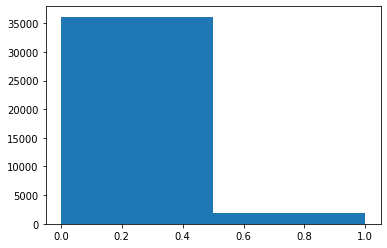

In [8]:
plt.hist(data['dank_level'], bins = 2)

In [9]:
imageDir = '/content/gdrive/My Drive/Colab Notebooks/Memes Project/raw_data/*'
image_files = glob.glob(imageDir)

In [10]:
len(image_files)

37039

In [11]:
image_files[0:2]

['/content/gdrive/My Drive/Colab Notebooks/Memes Project/raw_data/fhmf0n.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Memes Project/raw_data/fhmeyo.jpg']

In [12]:
def getDankLevel(imageLink):
  imgID = imageLink.split('/')[-1].split('.')[0] #find image id based on the file name
  return list(data.loc[data['id'] == imgID]['dank_level'])[0] #look up the dank_level based on the image id
getDankLevel(image_files[1])

0

In [13]:
dank_files = [img for img in image_files if getDankLevel(img) == 1]
not_dank_files = list(set(image_files) - set(dank_files))

#calculating the interval to seperate the train, validation, and test files
interval = len(dank_files)//4 
interval

dank_train = np.random.choice(dank_files, size=2*interval, replace=False)
not_dank_train = np.random.choice(not_dank_files, size=2*interval, replace=False)
dank_files = list(set(dank_files) - set(dank_train))
not_dank_files = list(set(not_dank_files) - set(not_dank_train))

dank_val = np.random.choice(dank_files, size=interval, replace=False)
not_dank_val = np.random.choice(not_dank_files, size=interval, replace=False)
dank_files = list(set(dank_files) - set(dank_val))
not_dank_files = list(set(not_dank_files) - set(not_dank_val))

dank_test = dank_files
not_dank_test = np.random.choice(not_dank_files, size=len(dank_test), replace=False)

#Checking the set sizes
print('Dank datasets:', len(dank_train), len(dank_val), len(dank_test))
print('Not dank datasets:', len(not_dank_train), len(not_dank_val), len(not_dank_test))

Dank datasets: 942 471 471
Not dank datasets: 942 471 471


In [14]:
with open('/content/gdrive/My Drive/Colab Notebooks/Memes Project/models/dank_test_inception.txt', 'w') as outfile:
  outfile.write("\n".join(dank_test))

In [15]:
with open('/content/gdrive/My Drive/Colab Notebooks/Memes Project/models/not_dank_test_inception.txt', 'w') as outfile:
  outfile.write("\n".join(not_dank_test))

In [16]:
def toString(arr):
  return [str(item) for item in arr]

In [17]:
IMG_DIM = (200, 200)
dank_train = toString(dank_train) #convert the array to string type
not_dank_train = toString(not_dank_train) #convert the array to string type
dank_val = toString(dank_val) #convert the array to string type
not_dank_val = toString(not_dank_val) #convert the array to string type

train_files = dank_train + not_dank_train
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)

validation_files = dank_val + not_dank_val
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train dataset shape: (1884, 200, 200, 3) 	Validation dataset shape: (942, 200, 200, 3)


In [18]:
train_labels = [getDankLevel(fn) for fn in train_files]
validation_labels = [getDankLevel(fn) for fn in validation_files]

(200, 200, 3)


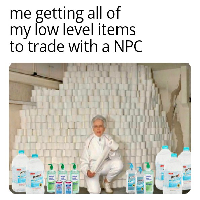

In [19]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [20]:
input_shape = (200, 200, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505]) #1 is dank, 0 is not dank

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0 0 0 0 0 0 0 0 0 0]


In [21]:
from keras import Model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

pre_trained_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)
layers = [(layer, layer.name, layer.trainable) for layer in pre_trained_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)    

,Layer Type,Layer Name,Layer Trainable
301,<keras.layers.core.Activation object at 0x7f01...,activation_88,True
302,<keras.layers.core.Activation object at 0x7f01...,activation_89,True
303,<keras.layers.core.Activation object at 0x7f01...,activation_92,True
304,<keras.layers.core.Activation object at 0x7f01...,activation_93,True
305,<keras.layers.normalization.BatchNormalization...,batch_normalization_94,True
306,<keras.layers.core.Activation object at 0x7f01...,activation_86,True
307,<keras.layers.merge.Concatenate object at 0x7f...,mixed9_1,True
308,<keras.layers.merge.Concatenate object at 0x7f...,concatenate_2,True
309,<keras.layers.core.Activation object at 0x7f01...,activation_94,True
310,<keras.layers.merge.Concatenate object at 0x7f...,mixed10,True


In [22]:
last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 10, 10, 768)


In [23]:
# Flatten the output layer to 1 dimension
x = Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

In [24]:
model = keras.Model(pre_trained_model.input, x) 

In [25]:
# Image Augmentation generator to create variety of images
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=32)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)       

In [26]:
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])              

In [27]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [28]:
history = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=50,
                              validation_data=val_generator, validation_steps=STEP_SIZE_VALID, 
                              verbose=1)     

Epoch 1/50
58/58 [==============================] - 43s 744ms/step - loss: 0.8146 - acc: 0.5319 - val_loss: 0.6703 - val_acc: 0.5691
Epoch 2/50
58/58 [==============================] - 28s 490ms/step - loss: 0.6855 - acc: 0.5740 - val_loss: 0.6443 - val_acc: 0.6020
Epoch 3/50
58/58 [==============================] - 28s 484ms/step - loss: 0.6644 - acc: 0.6096 - val_loss: 0.7272 - val_acc: 0.5954
Epoch 4/50
58/58 [==============================] - 28s 486ms/step - loss: 0.6417 - acc: 0.6371 - val_loss: 0.7710 - val_acc: 0.6106
Epoch 5/50
58/58 [==============================] - 28s 487ms/step - loss: 0.5977 - acc: 0.6798 - val_loss: 1.2194 - val_acc: 0.5998
Epoch 6/50
58/58 [==============================] - 28s 484ms/step - loss: 0.5787 - acc: 0.7046 - val_loss: 0.6430 - val_acc: 0.5792
Epoch 7/50
58/58 [==============================] - 28s 485ms/step - loss: 0.5489 - acc: 0.7268 - val_loss: 1.6484 - val_acc: 0.6150
Epoch 8/50
58/58 [==============================] - 28s 486ms/step - 

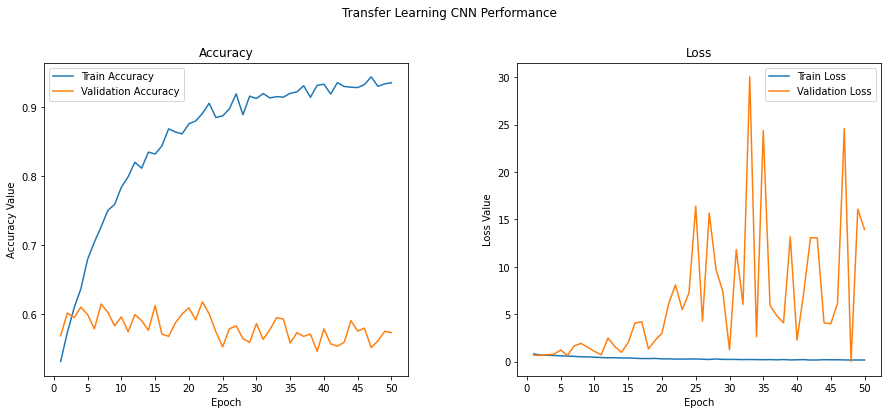

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
t = f.suptitle('Transfer Learning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [33]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [35]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Memes Project/models/finetune_img_aug_inception.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [36]:
results = {}
results['epoch_list'] = epoch_list
results['accuracy'] = toString(history.history['acc'])
results['val_accuracy'] = toString(history.history['val_acc'])
results['val_loss'] = toString(history.history['val_loss'])
results['loss'] = toString(history.history['loss'])

In [37]:
with open('/content/gdrive/My Drive/Colab Notebooks/Memes Project/models/finetune_img_aug_inception_results.json', 'w') as outfile:
  json.dump(results, outfile)